In [53]:
import numpy as np
import time
from ortools.sat.python import cp_model
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

Solver status: OPTIMAL
Solving time: 63.306 seconds
Sum of all integers: 470
Solution found:


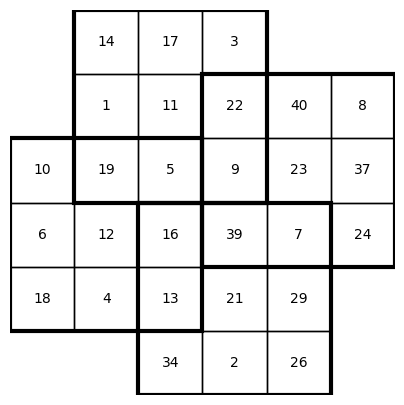

In [54]:
def n_square(i: int, j:int, n:int = 3, matrix_size: int = 6):
    """
    Given a position (i,j) representing the left top corner of a nxn submatrix, returns a boolean array 
    indicating the positions of such nxn submatrix inside the bigger square matrix of size: matrix_size 
    """
    matrix = np.full((matrix_size,matrix_size), False)
    matrix[i:i+n,j:j+n] = True

    return matrix

n = 6 #Grid size

lb = 0
ub = 9999

model = cp_model.CpModel()

X = np.array([[model.new_int_var(lb,ub, f"X({i},{j})") for j in range(n)] for i in range(n)])

magic_corners = [(0, 1), (2, 0), (3, 2), (1, 3)]

squares = [n_square(i, j) for i, j in magic_corners]

# Initialize all False array and then perform or operator across all squares
grid = np.zeros_like(squares[0], dtype=bool)
for a in squares:
    grid |= a

for i in range(n):
    for j in range(n):
        if grid[i,j]:
            model.Add(X[(i,j)] > 0)
        else:
            model.Add(X[(i,j)] == 0)

vars_in_squares = [X[i, j] for i in range(n) for j in range(n) if grid[i, j]] 
model.add_all_different(vars_in_squares)

for i, j in magic_corners: # Extract the 3x3 block 
    
    sq = [[X[i + r, j + c] for c in range(3)] for r in range(3)]

    # Row sums
    row_sums = [cp_model.LinearExpr.Sum(sq[r]) for r in range(3)]

    # Column sums
    col_sums = [cp_model.LinearExpr.Sum([sq[r][c] for r in range(3)]) for c in range(3)]

    main_diag = cp_model.LinearExpr.Sum([sq[d][d] for d in range(3)])
    anti_diag = cp_model.LinearExpr.Sum([sq[d][2 - d] for d in range(3)])

    sums = row_sums + col_sums + [main_diag, anti_diag]  # 8 sums total

    # Min/max variables for these 8 sums
    s_min = model.new_int_var(0, 3 * ub, f"s_min_{i}_{j}")
    s_max = model.new_int_var(0, 3 * ub, f"s_max_{i}_{j}")

    model.add_min_equality(s_min, sums)
    model.add_max_equality(s_max, sums)

    # Impose: all 8 sums differ by at most 1
    model.add(s_max - s_min <= 1)


model.Minimize(cp_model.LinearExpr.Sum([X[i, j] for i in range(n) for j in range(n)]))
solver = cp_model.CpSolver()


start_time = time.time()

status = solver.solve(model)

elapsed_time = time.time() - start_time

def plot_solution(sol, grid, n=6):
    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_xlim(0, n)
    ax.set_ylim(0, n)
    ax.set_aspect("equal")
    ax.axis("off")

    # Draw the grid 
    for i in range(n):
        for j in range(n):
            if grid[i, j]:
                rect = Rectangle((j, n - 1 - i), 1, 1, fill=False, linewidth=1, edgecolor="black")
                ax.add_patch(rect)

                ax.text(j + 0.5, n - 1 - i + 0.5, f"{int(sol[i,j])}",
                        ha="center", va="center", fontsize=10)

    # Draw 3x3 squares
    for (r, c) in magic_corners:
        rect = Rectangle((c, n - r), 3, -3, fill=False, 
                         linewidth=3, edgecolor="black")
        ax.add_patch(rect)

    plt.show()


sol = np.array([[solver.Value(X[i,j]) for j in range(n)] for i in range(n)])
grid = np.zeros((n, n), dtype=bool)
for (r, c) in magic_corners:
    grid[r:r+3, c:c+3] = True


# Results
print(f"Solver status: {solver.StatusName(status)}")
print(f"Solving time: {elapsed_time:.3f} seconds")


if status in [cp_model.OPTIMAL, cp_model.FEASIBLE]:
    print(f"Sum of all integers: {sum(sum(sol))}")
    print("Solution found:")
    plot_solution(sol, grid, n)
else:
    print("No solution found.")
